In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy.io          import fits
from iminuit import Minuit
import emcee
import corner

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.3 installed at /home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/camb


In [2]:
#Run Camb on a sample parameter set

In [3]:
#Set up a new set of parameters for CAMB
#ombh2 – (float64) Omega_baryon h^2
#omch2 – (float64) Omega_cdm h^2
#omk – (float64) Omega_K
#omnuh2 – (float64) Omega_massive_neutrino h^2
#H0 – (float64) Hubble parameter is km/s/Mpc units
#tau - optical depth
#mnu – sum of neutrino masses (in eV). Omega_nu is calculated approximately from this assuming neutrinos non-relativistic today; i.e. here is defined as a direct proxy for Omega_nu. Internally the actual physical mass is calculated from the Omega_nu accounting for small mass-dependent velocity corrections but neglecting spectral distortions to the neutrino distribution. Set the neutrino field values directly if you need finer control or more complex neutrino models.
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0,tau=0.078)

# The initial power spectrum is set here, separately from the rest of cosmology
#Inflation parameters
#As – comoving curvature power at k=pivot_scalar (As)
#ns – scalar spectral index ns
#r – tensor to scalar ratio at pivot
#pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.InitPower.set_params(As=2.2e-9, ns=0.9682, r=0)
# Set how far in multipole we want the power spectra, and turn on defaults for the params.
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#What are the different power spectra we have calculated?
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [6]:
totCL=powers['total']

In [7]:
#Load in the current binned planck data, from https://lambda.gsfc.nasa.gov/graphics/tt_spectrum/
planck=pd.read_csv('TT_data_2020aug_csv_format.dat',sep=' *, *')
planck=planck.sort_values('l_center')

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


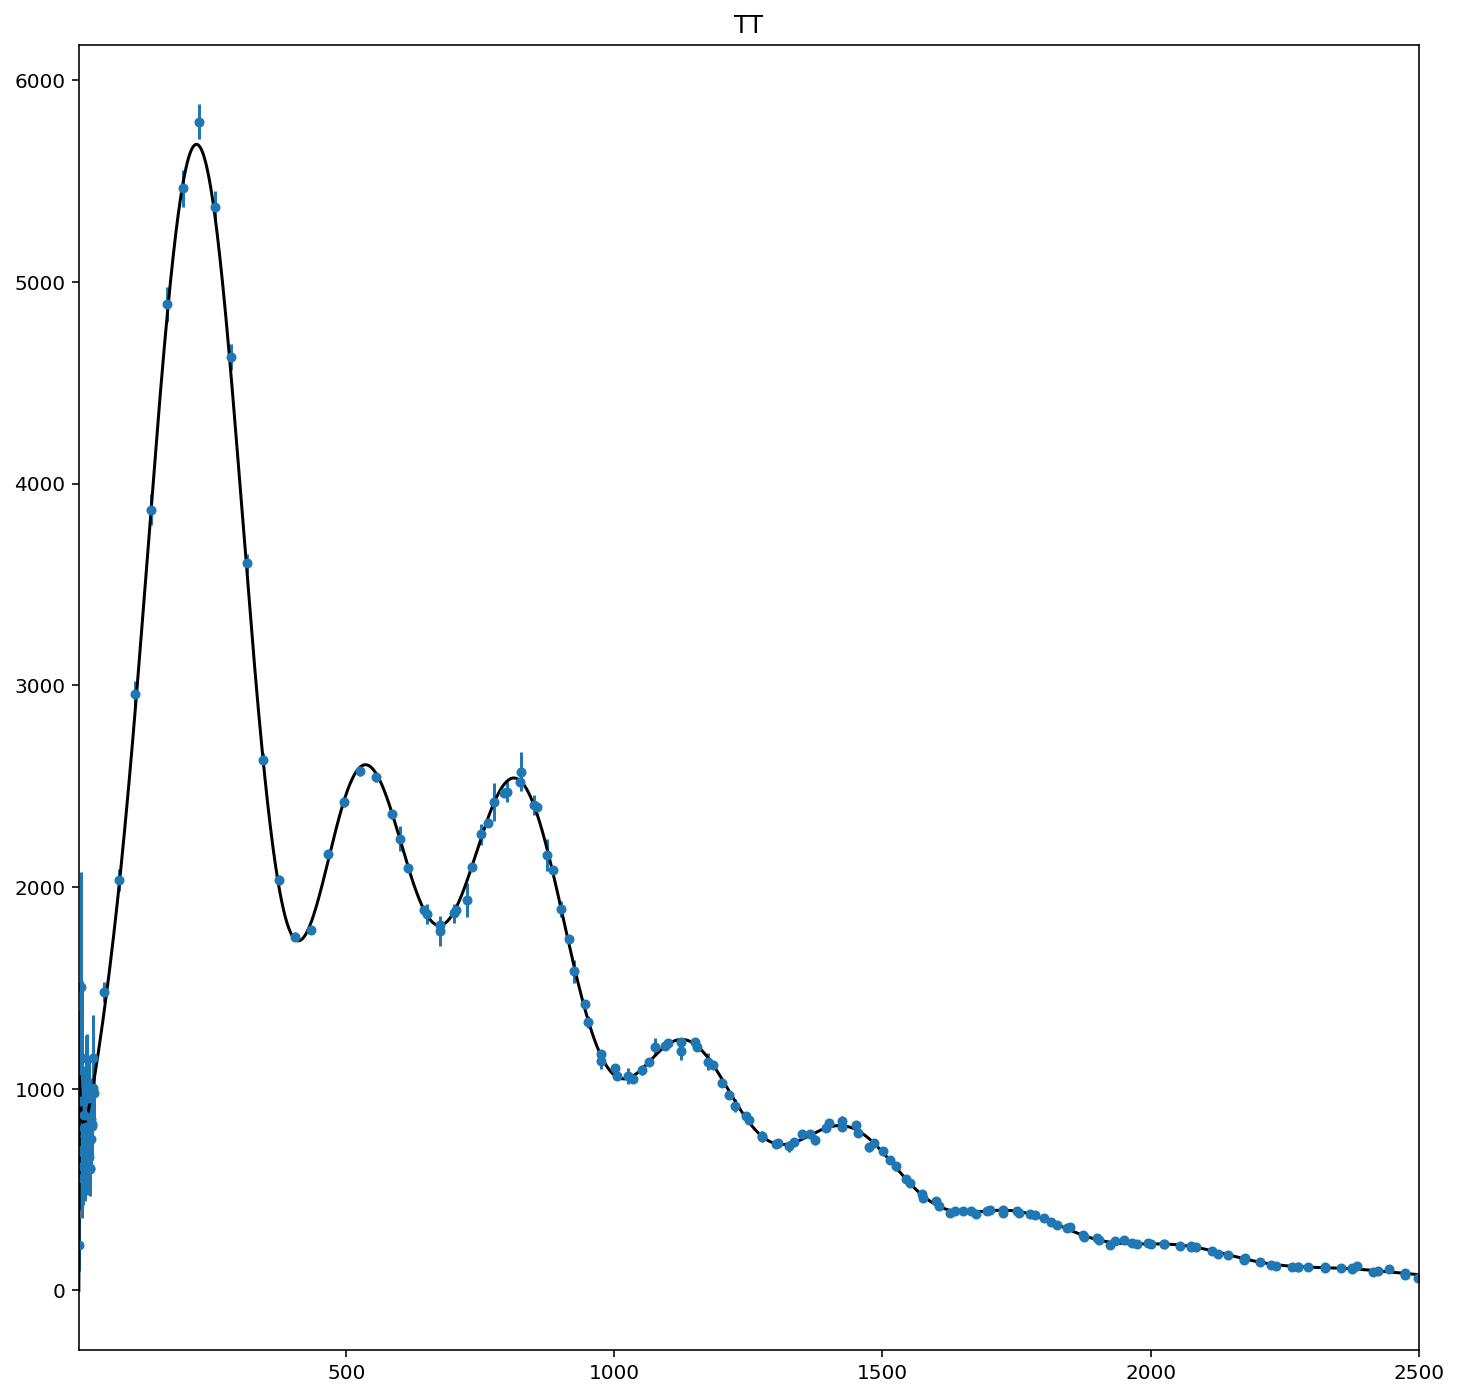

In [8]:
#plot the total CMB power spectra versus theory

ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(1,1, figsize = (12,12))
tot=ax.plot(ls,totCL[:,0], color='k')
dat=ax.errorbar(planck.l_center, planck.Power, yerr=planck.Sigma_minus, fmt='o',markersize=4)
ax.set_title('TT')
ax.set_xlim([2,2500]);

In [9]:
#The above binned data does not state the bins used, making comparison to theory difficult
#Instead, let's go straight to Planck and look at unbinned data.

#This fits file has 12 different extensions, with polarization and binned/unbinned data.
#We want the 8th extension, the unbinned TT data
#from https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/previews/ps_index.html
planck2=fits.open('COM_PowerSpect_CMB_R2.02.fits')

In [10]:
unbinned=pd.DataFrame.from_records(planck2[8].data.tolist(), columns=planck2[8].data.dtype.names)
unbinned

,ELL,D_ELL,ERR
0,30,1096.176025,278.186005
1,31,788.986023,277.345001
2,32,1550.618042,276.714996
3,33,1096.446045,276.266998
4,34,987.330017,275.997009
...,...,...,...
2474,2504,205.011002,109.179001
2475,2505,66.652000,109.466003
2476,2506,-162.621994,109.752998
2477,2507,-73.422997,110.069000


In [11]:
#Create a theory vector which has exactly the same ell values as the dataset
t=pd.DataFrame({'D_ELL':powers['total'][:,0]})
t=t.drop(range(30)).reset_index(drop=True)
t=t.drop(range(2479,2521))
t

,D_ELL
0,1055.336762
1,1071.450787
2,1088.186543
3,1105.007248
4,1121.881124
...,...
2474,76.374975
2475,76.156755
2476,75.940070
2477,75.725130


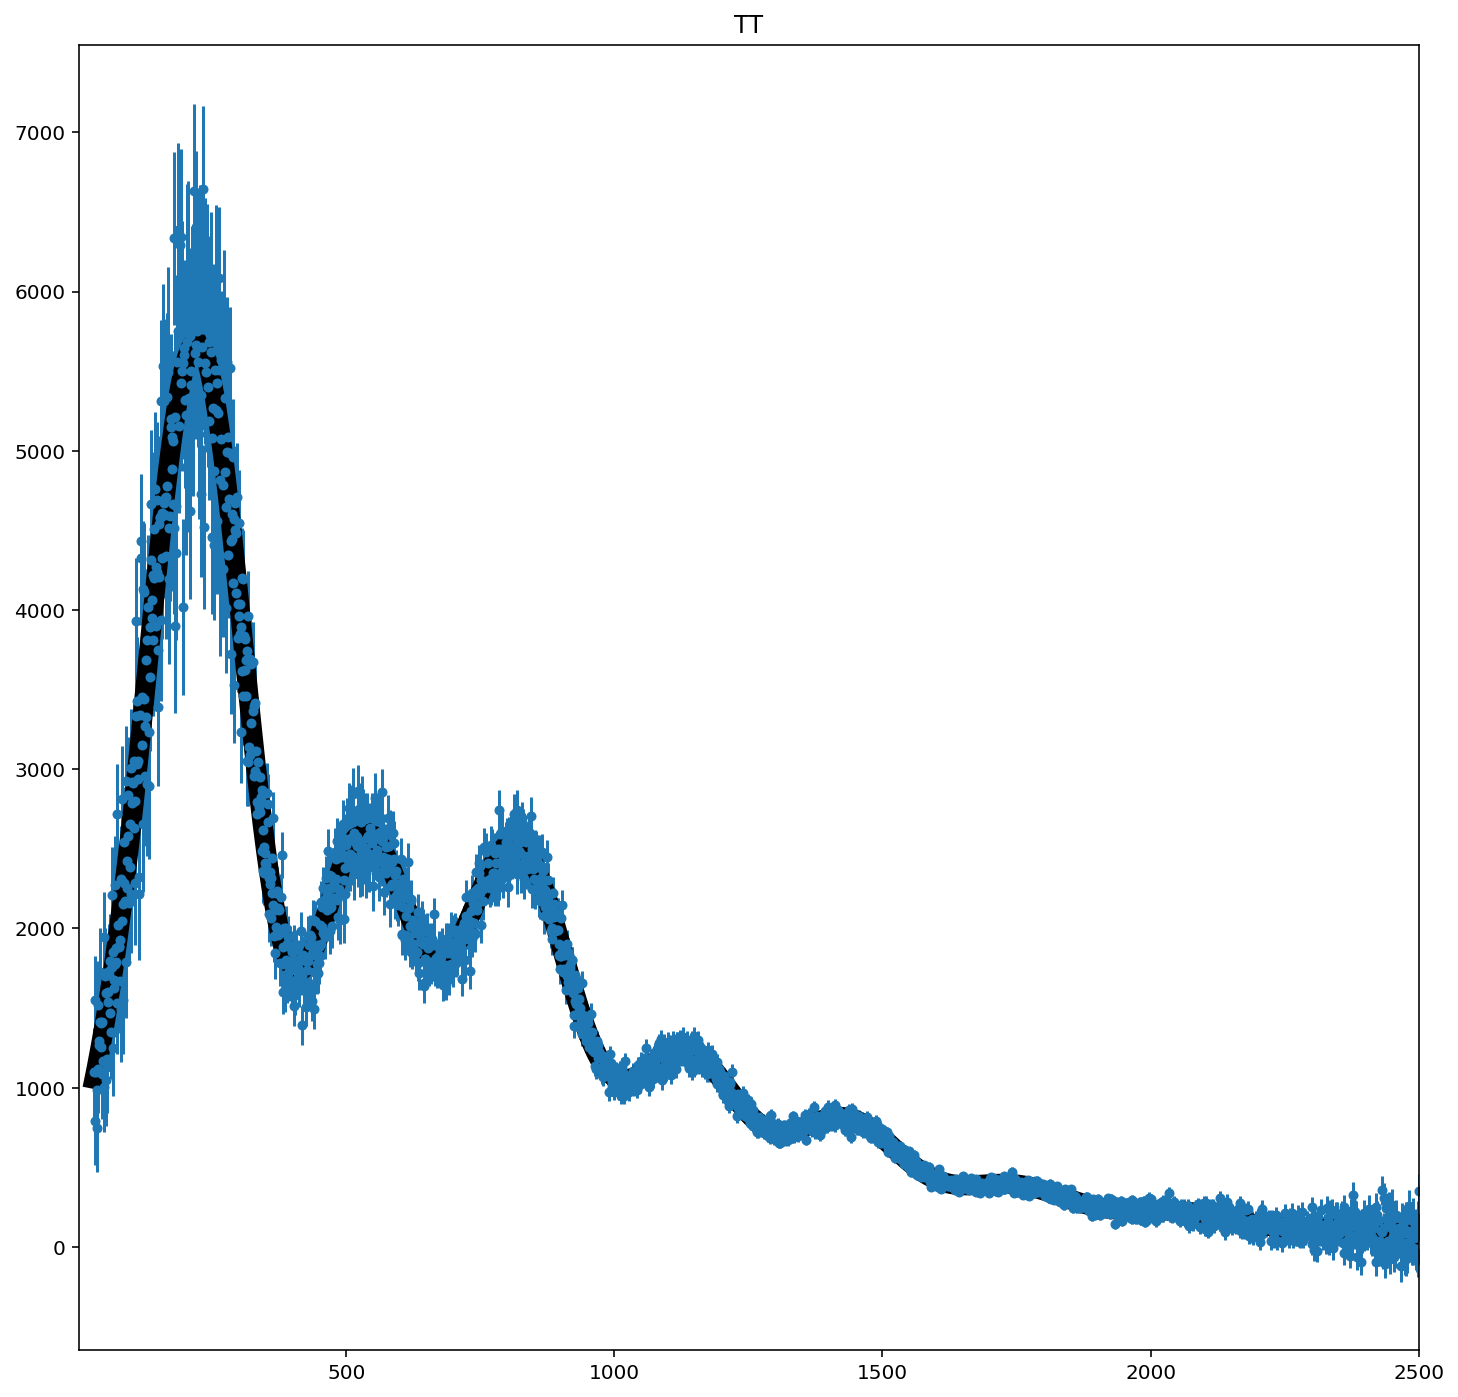

In [12]:
#plot the total lensed CMB power spectra , unbinned data

fig, ax = plt.subplots(1,1, figsize = (12,12))
tot=ax.plot(unbinned.ELL,t.D_ELL, color='k',linewidth=10)
dat=ax.errorbar(unbinned.ELL, unbinned.D_ELL, yerr=unbinned.ERR, fmt='o',markersize=4)
ax.set_title('TT')
ax.set_xlim([2,2500]);

In [13]:
#Here I begin parameter optimization. Start by defining an origin vector.
#The parameters being varied are in this vector. Those that are globally-defined particles are
#everything else.

In [14]:
H0=67.26
ombh2=0.022
omch2=0.1199
mnu=0.06
omk=0
tau=0.078
As=2.2e-9
ns=0.9682
r=0

origin=[H0,ombh2,omch2,omk,tau]

In [28]:
def lnlike(parameters):
    global unbinned, count
    global ns, r,mnu, As
    global min,max
    H0,ombh2,omch2,omk,tau  = parameters
    
    #print(count,parameters)
    count+=1
    
    #Get the theory vector, t

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0,tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=r)
    pars.set_for_lmax(2500, lens_potential_accuracy=0);
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    #Drop Ell values not in the dataset

    t=pd.DataFrame({'D_ELL':powers['total'][:,0]})
    t=t.drop(range(30)).reset_index(drop=True)
    t=t.drop(range(2479,2521))
    
    #The likelihood; note a minimizer like minuit wants this positive; for MCMC flip the sign

    loglike=(unbinned.D_ELL-t.D_ELL)**2/(2.*unbinned.ERR**2)
    loglike=np.sum(loglike)
    
    #Use a flat prior with bounds defined in min and max
    withinlimits=[]
    for i in range(len(parameters)):
        withinlimits=np.append( withinlimits, (min[i]<parameters[i]<max[i]))
    if np.all(withinlimits.astype(bool)):
        lp=0
    else:
        lp=np.inf
        
    return loglike+lp

In [16]:
#Same function, for algorithms seeking to maximize
def nlnlike(parameters):
    return -lnlike(parameters)

In [17]:
#I find it reassuring to see the function evalutations coming in, here is a globally-defined count.
count=0

In [18]:
#These vectors define the bounds for searching on, in the same order as the origin vector.
min=np.array([50,0.01,0.01,-1.0,0.05])
max=np.array([100,0.1,0.2,1.0,0.1])

bnds=[(x,y) for x, y in zip(min, max)]

In [19]:
lnlike(origin)

0 [67.26, 0.022, 0.1199, 0, 0.078]


1275.3898567582867

In [20]:
labels=[r'$H_0$', r'$\Omega_b h^2$', r'$\Omega_c h^2$', r'$\Omega_k$', r'$\tau$']

In [21]:
#Errordef=0.5 for likelihood, for obscure reasons
m = Minuit.from_array_func(lnlike, origin,limit=bnds,errordef=0.5, pedantic=False,name=labels)

In [22]:
m.migrad()

1 [6.726e+01 2.200e-02 1.199e-01 0.000e+00 7.800e-02]
2 [6.72765949e+01 2.20000000e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
3 [6.72434089e+01 2.20000000e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
4 [6.72632221e+01 2.20000000e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
5 [6.7256778e+01 2.2000000e-02 1.1990000e-01 0.0000000e+00 7.8000000e-02]
6 [6.72600000e+01 2.20054272e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
7 [6.72600000e+01 2.19945739e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
8 [6.72600000e+01 2.20027923e-02 1.19900000e-01 0.00000000e+00
 7.80000000e-02]
9 [6.7260000e+01 2.1997208e-02 1.1990000e-01 0.0000000e+00 7.8000000e-02]
10 [6.72600000e+01 2.20000000e-02 1.19929574e-01 0.00000000e+00
 7.80000000e-02]
11 [6.72600000e+01 2.20000000e-02 1.19870424e-01 0.00000000e+00
 7.80000000e-02]
12 [6.72600000e+01 2.20000000e-02 1.19907119e-01 0.00000000e+00
 7.80000000e-02]
13 [6.72600000e+01 2.20000000e-02 1.19892881e-01 0.00000000e+00
 7.80000000

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1272                       │         Nfcn = 97 (97 total)         │
│ EDM = 2.31e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name           │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $H_0$          │   67.8    │    0.5    │            │            │   50    │   100   │       │
│ 1 │ $\Omega_b h^2$ │ 22.32e-3  │  0.20e-3  │            │            │  0.01   │   0.1   │       │
│ 2 │ $\Omega_c h^2$ │  0.1187   │  0.0012   │            │            │  0.01   │   0.2   │       │
│ 3 │ $\Omega_k$     │    0.0    │    0.8    │            │            │   -1    │    1    │       │
│ 4 │ $\tau$         │  0.0800   │  0.0012   │            │            │  0.05   │   0.1   │       │
└───┴────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

98 [6.67582373e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
99 [6.67582373e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
100 [6.67582373e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
101 [6.67582373e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
102 [6.67582373e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
103 [6.67582373e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
104 [6.67582373e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
105 [6.67582373e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
106 [6.67582373e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
107 [6.67582373e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
108 [6.67582373e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
109 [6.67582373e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
110 [6.67582373e+0

198 [6.68418556e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
199 [6.68418556e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
200 [6.68418556e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
201 [6.68418556e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
202 [6.68418556e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
203 [6.68418556e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
204 [6.68418556e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
205 [6.68418556e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
206 [6.68418556e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
207 [6.68418556e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
208 [6.68418556e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
209 [6.68418556e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
210 [6.68418556e

298 [6.69254739e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
299 [6.69254739e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
300 [6.69254739e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
301 [6.69254739e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
302 [6.69254739e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
303 [6.69254739e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
304 [6.69254739e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
305 [6.69254739e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
306 [6.69254739e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
307 [6.69254739e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
308 [6.69254739e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
309 [6.69254739e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
310 [6.69254739e

398 [6.70090923e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
399 [6.70090923e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
400 [6.70090923e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
401 [6.70090923e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
402 [6.70090923e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
403 [6.70090923e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
404 [6.70090923e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
405 [6.70090923e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
406 [6.70090923e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
407 [6.70090923e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
408 [6.70090923e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
409 [6.70090923e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
410 [6.70090923e

498 [6.70927106e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
499 [6.70927106e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
500 [6.70927106e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
501 [6.70927106e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
502 [6.70927106e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
503 [6.70927106e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
504 [6.70927106e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
505 [6.70927106e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
506 [6.70927106e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
507 [6.70927106e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
508 [6.70927106e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
509 [6.70927106e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
510 [6.70927106e

598 [6.71763289e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
599 [6.71763289e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
600 [6.71763289e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
601 [6.71763289e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
602 [6.71763289e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
603 [6.71763289e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
604 [6.71763289e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
605 [6.71763289e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
606 [6.71763289e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
607 [6.71763289e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
608 [6.71763289e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
609 [6.71763289e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
610 [6.71763289e

698 [6.72599473e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
699 [6.72599473e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
700 [6.72599473e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
701 [6.72599473e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
702 [6.72599473e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
703 [6.72599473e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
704 [6.72599473e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
705 [6.72599473e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
706 [6.72599473e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
707 [6.72599473e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
708 [6.72599473e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
709 [6.72599473e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
710 [6.72599473e

798 [6.73435656e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
799 [6.73435656e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
800 [6.73435656e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
801 [6.73435656e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
802 [6.73435656e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
803 [6.73435656e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
804 [6.73435656e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
805 [6.73435656e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
806 [6.73435656e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
807 [6.73435656e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
808 [6.73435656e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
809 [6.73435656e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
810 [6.73435656e

898 [6.74271839e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
899 [6.74271839e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
900 [6.74271839e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
901 [6.74271839e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
902 [6.74271839e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
903 [6.74271839e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
904 [6.74271839e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
905 [6.74271839e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
906 [6.74271839e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
907 [6.74271839e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
908 [6.74271839e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
909 [6.74271839e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
910 [6.74271839e

998 [6.75108023e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
999 [6.75108023e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1000 [6.75108023e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1001 [6.75108023e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1002 [6.75108023e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1003 [6.75108023e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1004 [6.75108023e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1005 [6.75108023e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1006 [6.75108023e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1007 [6.75108023e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1008 [6.75108023e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1009 [6.75108023e+01 2.20958746e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1010 [

1097 [6.75526114e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1098 [6.75944206e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1099 [6.75944206e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1100 [6.75944206e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1101 [6.75944206e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1102 [6.75944206e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1103 [6.75944206e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1104 [6.75944206e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1105 [6.75944206e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1106 [6.75944206e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1107 [6.75944206e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1108 [6.75944206e+01 2.20795526e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1109

1196 [6.76362297e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1197 [6.76362297e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1198 [6.76780389e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1199 [6.76780389e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1200 [6.76780389e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1201 [6.76780389e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1202 [6.76780389e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1203 [6.76780389e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1204 [6.76780389e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1205 [6.76780389e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1206 [6.76780389e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1207 [6.76780389e+01 2.20632305e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1208

1295 [6.77198481e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1296 [6.77198481e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1297 [6.77198481e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1298 [6.77616572e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1299 [6.77616572e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1300 [6.77616572e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1301 [6.77616572e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1302 [6.77616572e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1303 [6.77616572e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1304 [6.77616572e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1305 [6.77616572e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1306 [6.77616572e+01 2.20469084e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1307

1394 [6.78034664e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1395 [6.78034664e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1396 [6.78034664e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1397 [6.78034664e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1398 [6.78452756e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1399 [6.78452756e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1400 [6.78452756e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1401 [6.78452756e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1402 [6.78452756e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1403 [6.78452756e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1404 [6.78452756e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1405 [6.78452756e+01 2.20305864e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1406

1493 [6.78870847e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1494 [6.78870847e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1495 [6.78870847e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1496 [6.78870847e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1497 [6.78870847e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1498 [6.79288939e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1499 [6.79288939e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1500 [6.79288939e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1501 [6.79288939e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1502 [6.79288939e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1503 [6.79288939e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1504 [6.79288939e+01 2.20142643e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1505

1592 [6.79707031e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1593 [6.79707031e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1594 [6.79707031e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1595 [6.79707031e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1596 [6.79707031e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1597 [6.79707031e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1598 [6.80125122e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1599 [6.80125122e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1600 [6.80125122e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1601 [6.80125122e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1602 [6.80125122e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1603 [6.80125122e+01 2.19979422e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1604

1691 [6.80543214e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1692 [6.80543214e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1693 [6.80543214e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1694 [6.80543214e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1695 [6.80543214e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1696 [6.80543214e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1697 [6.80543214e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1698 [6.80961306e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1699 [6.80961306e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1700 [6.80961306e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1701 [6.80961306e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1702 [6.80961306e+01 2.19816202e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1703

1790 [6.81379397e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1791 [6.81379397e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1792 [6.81379397e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1793 [6.81379397e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1794 [6.81379397e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1795 [6.81379397e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1796 [6.81379397e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1797 [6.81379397e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1798 [6.81797489e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1799 [6.81797489e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1800 [6.81797489e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1801 [6.81797489e+01 2.19652981e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1802

1889 [6.82215581e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1890 [6.82215581e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1891 [6.82215581e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1892 [6.82215581e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1893 [6.82215581e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1894 [6.82215581e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1895 [6.82215581e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1896 [6.82215581e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1897 [6.82215581e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1898 [6.82633672e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1899 [6.82633672e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1900 [6.82633672e+01 2.19489760e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1901

1988 [6.83051764e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1989 [6.83051764e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1990 [6.83051764e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1991 [6.83051764e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1992 [6.83051764e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1993 [6.83051764e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1994 [6.83051764e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1995 [6.83051764e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1996 [6.83051764e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1997 [6.83051764e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1998 [6.83469856e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
1999 [6.83469856e+01 2.19326540e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2000

2087 [6.83887947e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2088 [6.83887947e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2089 [6.83887947e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2090 [6.83887947e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2091 [6.83887947e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2092 [6.83887947e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2093 [6.83887947e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2094 [6.83887947e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2095 [6.83887947e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2096 [6.83887947e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2097 [6.83887947e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2098 [6.84306039e+01 2.19163319e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2099

2186 [6.84724131e+01 2.25365704e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2187 [6.84724131e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2188 [6.84724131e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2189 [6.84724131e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2190 [6.84724131e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2191 [6.84724131e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2192 [6.84724131e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2193 [6.84724131e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2194 [6.84724131e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2195 [6.84724131e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2196 [6.84724131e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2197 [6.84724131e+01 2.27161131e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2198

2285 [6.85560314e+01 2.25202483e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2286 [6.85560314e+01 2.25365704e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2287 [6.85560314e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2288 [6.85560314e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2289 [6.85560314e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2290 [6.85560314e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2291 [6.85560314e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2292 [6.85560314e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2293 [6.85560314e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2294 [6.85560314e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2295 [6.85560314e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2296 [6.85560314e+01 2.26997910e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2297

2384 [6.86396497e+01 2.25039263e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2385 [6.86396497e+01 2.25202483e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2386 [6.86396497e+01 2.25365704e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2387 [6.86396497e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2388 [6.86396497e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2389 [6.86396497e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2390 [6.86396497e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2391 [6.86396497e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2392 [6.86396497e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2393 [6.86396497e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2394 [6.86396497e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2395 [6.86396497e+01 2.26834690e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2396

2483 [6.87232681e+01 2.24876042e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2484 [6.87232681e+01 2.25039263e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2485 [6.87232681e+01 2.25202483e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2486 [6.87232681e+01 2.25365704e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2487 [6.87232681e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2488 [6.87232681e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2489 [6.87232681e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2490 [6.87232681e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2491 [6.87232681e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2492 [6.87232681e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2493 [6.87232681e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2494 [6.87232681e+01 2.26671469e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2495

2582 [6.88068864e+01 2.24712821e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2583 [6.88068864e+01 2.24876042e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2584 [6.88068864e+01 2.25039263e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2585 [6.88068864e+01 2.25202483e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2586 [6.88068864e+01 2.25365704e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2587 [6.88068864e+01 2.25528924e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2588 [6.88068864e+01 2.25692145e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2589 [6.88068864e+01 2.25855366e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2590 [6.88068864e+01 2.26018586e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2591 [6.88068864e+01 2.26181807e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2592 [6.88068864e+01 2.26345028e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2593 [6.88068864e+01 2.26508248e-02 1.18721639e-01 0.00000000e+00
 8.00449323e-02]
2594

(array([66.75823727, 66.80004643, 66.8418556 , 66.88366476, 66.92547393,
        66.9672831 , 67.00909226, 67.05090143, 67.09271059, 67.13451976,
        67.17632893, 67.21813809, 67.25994726, 67.30175642, 67.34356559,
        67.38537475, 67.42718392, 67.46899309, 67.51080225, 67.55261142,
        67.59442058, 67.63622975, 67.67803892, 67.71984808, 67.76165725,
        67.80346641, 67.84527558, 67.88708474, 67.92889391, 67.97070308,
        68.01251224, 68.05432141, 68.09613057, 68.13793974, 68.17974891,
        68.22155807, 68.26336724, 68.3051764 , 68.34698557, 68.38879473,
        68.4306039 , 68.47241307, 68.51422223, 68.5560314 , 68.59784056,
        68.63964973, 68.6814589 , 68.72326806, 68.76507723, 68.80688639]),
 array([0.02191633, 0.02193265, 0.02194898, 0.0219653 , 0.02198162,
        0.02199794, 0.02201426, 0.02203059, 0.02204691, 0.02206323,
        0.02207955, 0.02209587, 0.0221122 , 0.02212852, 0.02214484,
        0.02216116, 0.02217748, 0.02219381, 0.02221013, 0.022226

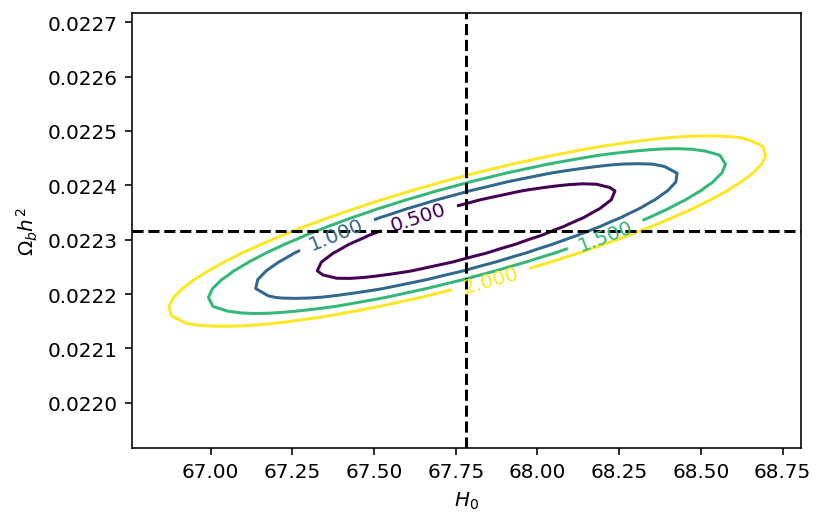

In [23]:
m.draw_contour(r'$H_0$', r'$\Omega_b h^2$')

In [27]:
H0,ombh2,omch2,omk,tau = m.np_values()

In [28]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0,tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=r)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

t=pd.DataFrame({'D_ELL':powers['total'][:,0]})
t=t.drop(range(30)).reset_index(drop=True)
t=t.drop(range(2479,2521))

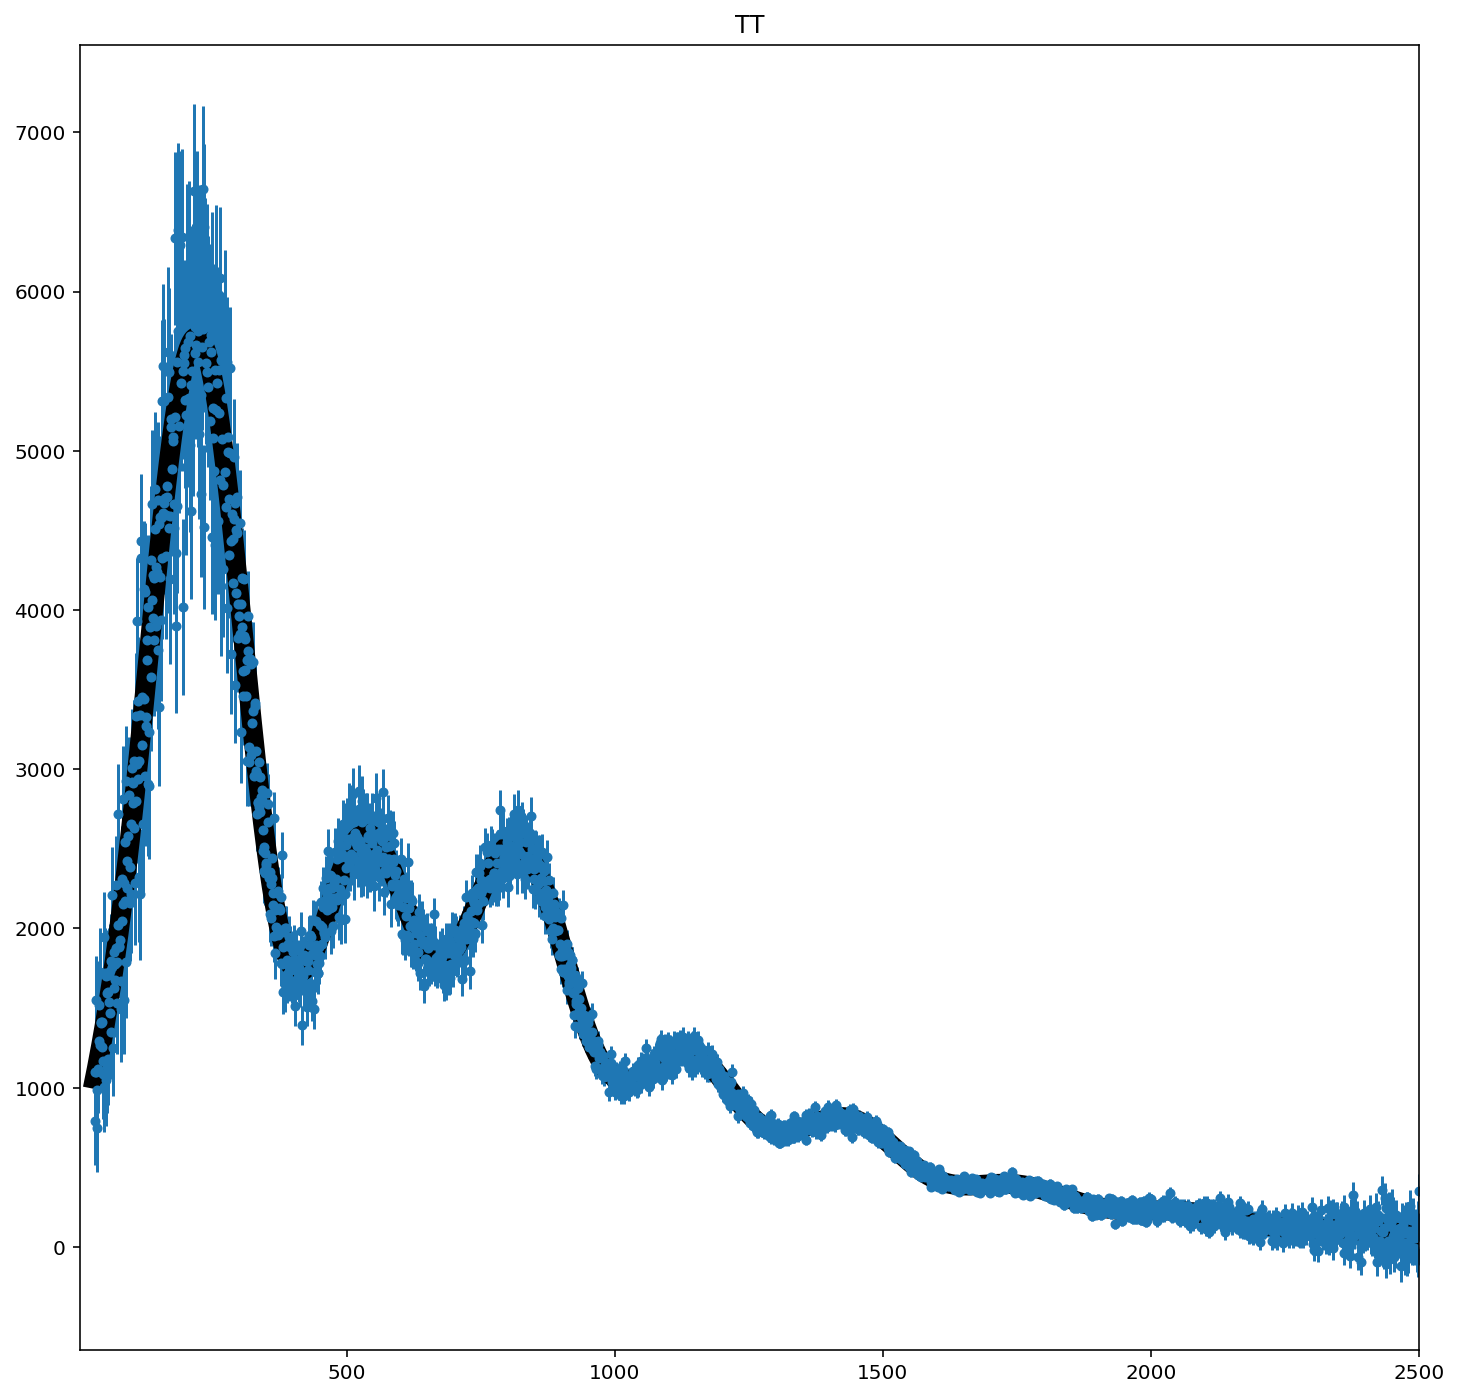

In [29]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference

#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

fig, ax = plt.subplots(1,1, figsize = (12,12))
tot=ax.plot(unbinned.ELL,t.D_ELL, color='k',linewidth=10)
dat=ax.errorbar(unbinned.ELL, unbinned.D_ELL, yerr=unbinned.ERR, fmt='o',markersize=4)
ax.set_title('TT')
ax.set_xlim([2,2500]);

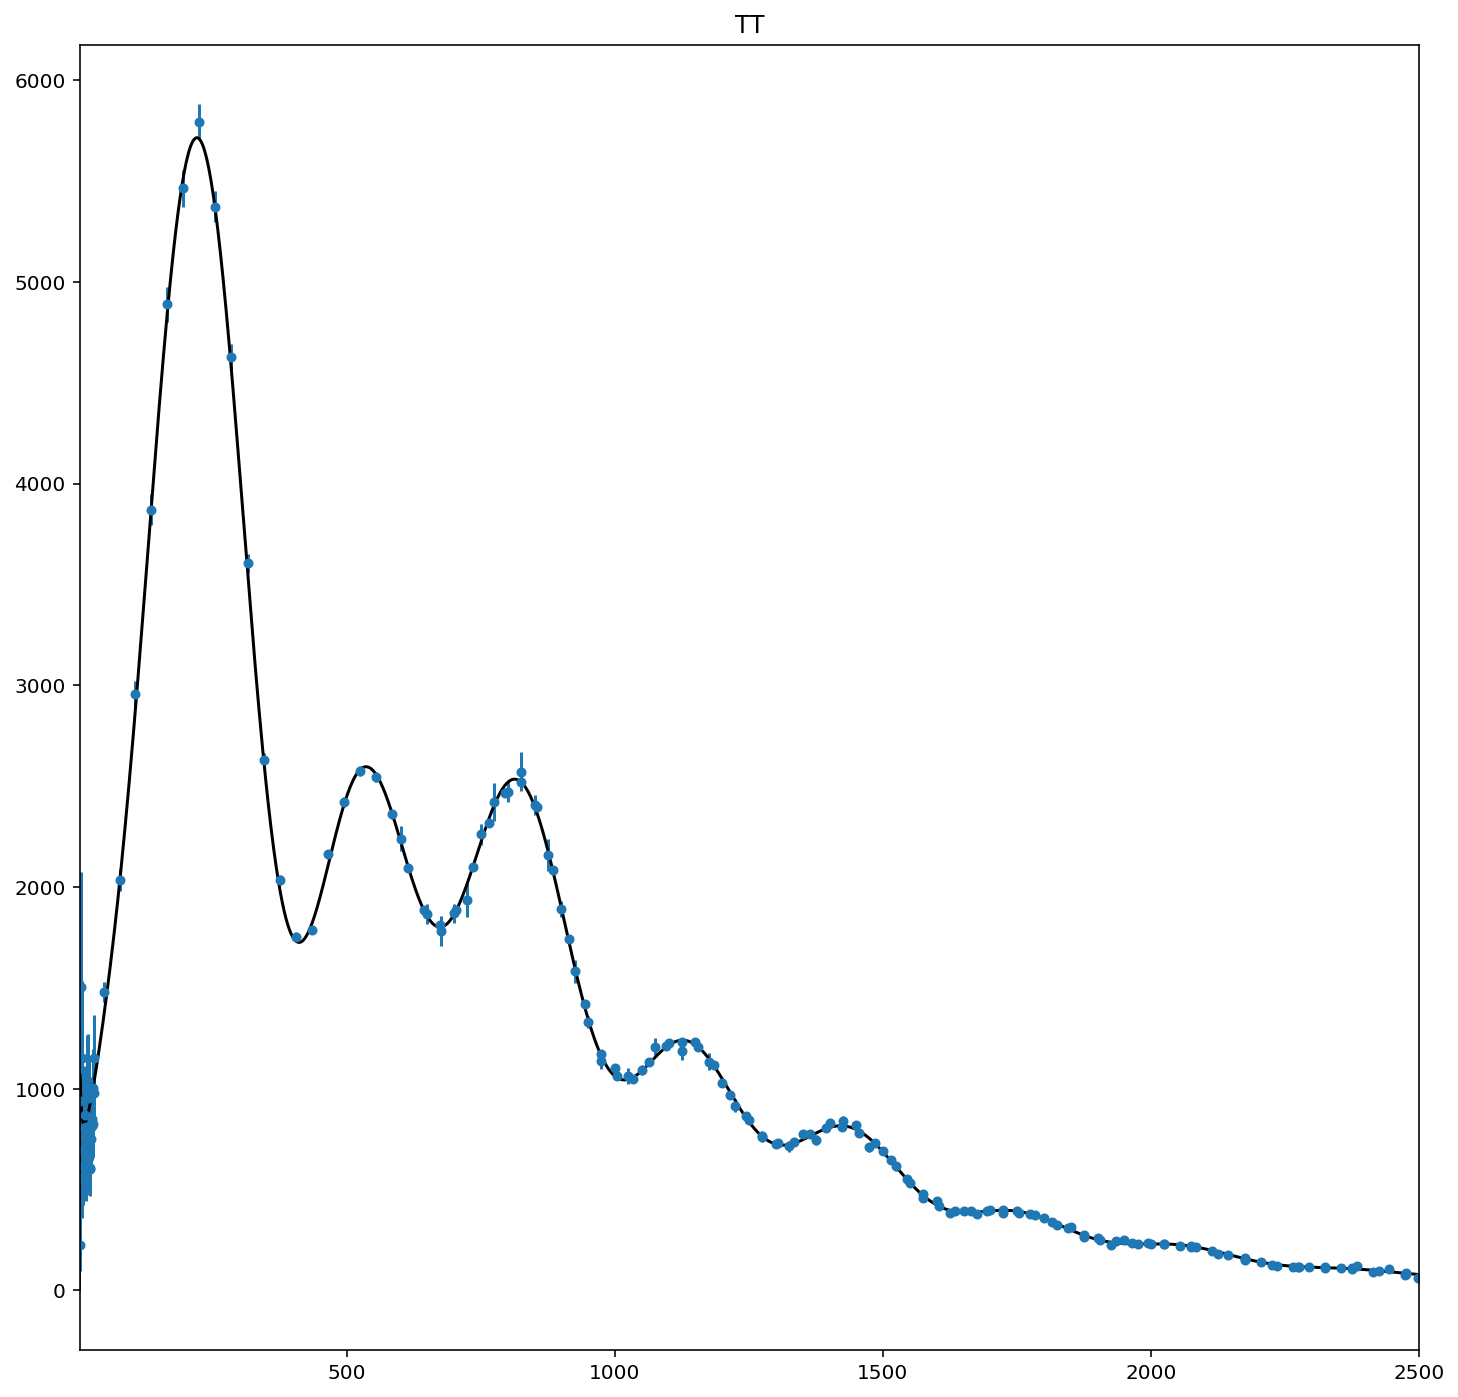

In [30]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(1,1, figsize = (12,12))
tot=ax.plot(ls,totCL[:,0], color='k')
dat=ax.errorbar(planck.l_center, planck.Power, yerr=planck.Sigma_minus, fmt='o',markersize=4)
ax.set_title('TT')
ax.set_xlim([2,2500]);

In [36]:
#The error on Omega_k given by minuit occasionally initializes a walker out of bounds
#(i.e. greater than 1).
#To avoid that, I set it by hand here
m.np_errors()[3]=0.25

In [26]:
#Parameters that Paxton's mcmc is initialized with
ndim, nwalkers = len(m.np_values()),40
pos = [m.np_values() + np.random.normal(0,m.np_errors()) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, nlnlike)

In [29]:
sampler.run_mcmc(pos, 6000,progress=True);

  0%|          | 0/6000 [00:00<?, ?it/s]/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 115/6000 [2:36:20<132:10:59, 80.86s/it]Traceback (most recent call last):
  File "/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-16-785143896b87>", line 3, in nlnlike
    return -lnlike(parameters)
  File "<ipython-input-28-6c3e180a880b>", line 16, in lnlike
    results = camb.get_results(pars)
  File "/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/camb/camb.py", line 35, in get_results
    res.calc_power_spectra(params)
  File "/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.7/site-packages/camb/results.py", line 329, in calc_power_spectra
    self.calc_transfers(params, only_transfers=Fa

emcee: Exception while calling your likelihood function:
  params: [6.81455151e+01 2.23154029e-02 1.18032372e-01 8.51886013e-01
 8.12311158e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [30]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_best=flat_chain[max_prob_idx]
mcmc_best

array([ 6.77960431e+01,  2.23193011e-02,  1.18727818e-01, -2.55195055e-01,
        7.99774448e-02])

In [31]:
flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)

In [32]:
from IPython.display import display, Math

mcmc_50=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    mcmc_50=np.append(mcmc_50,mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

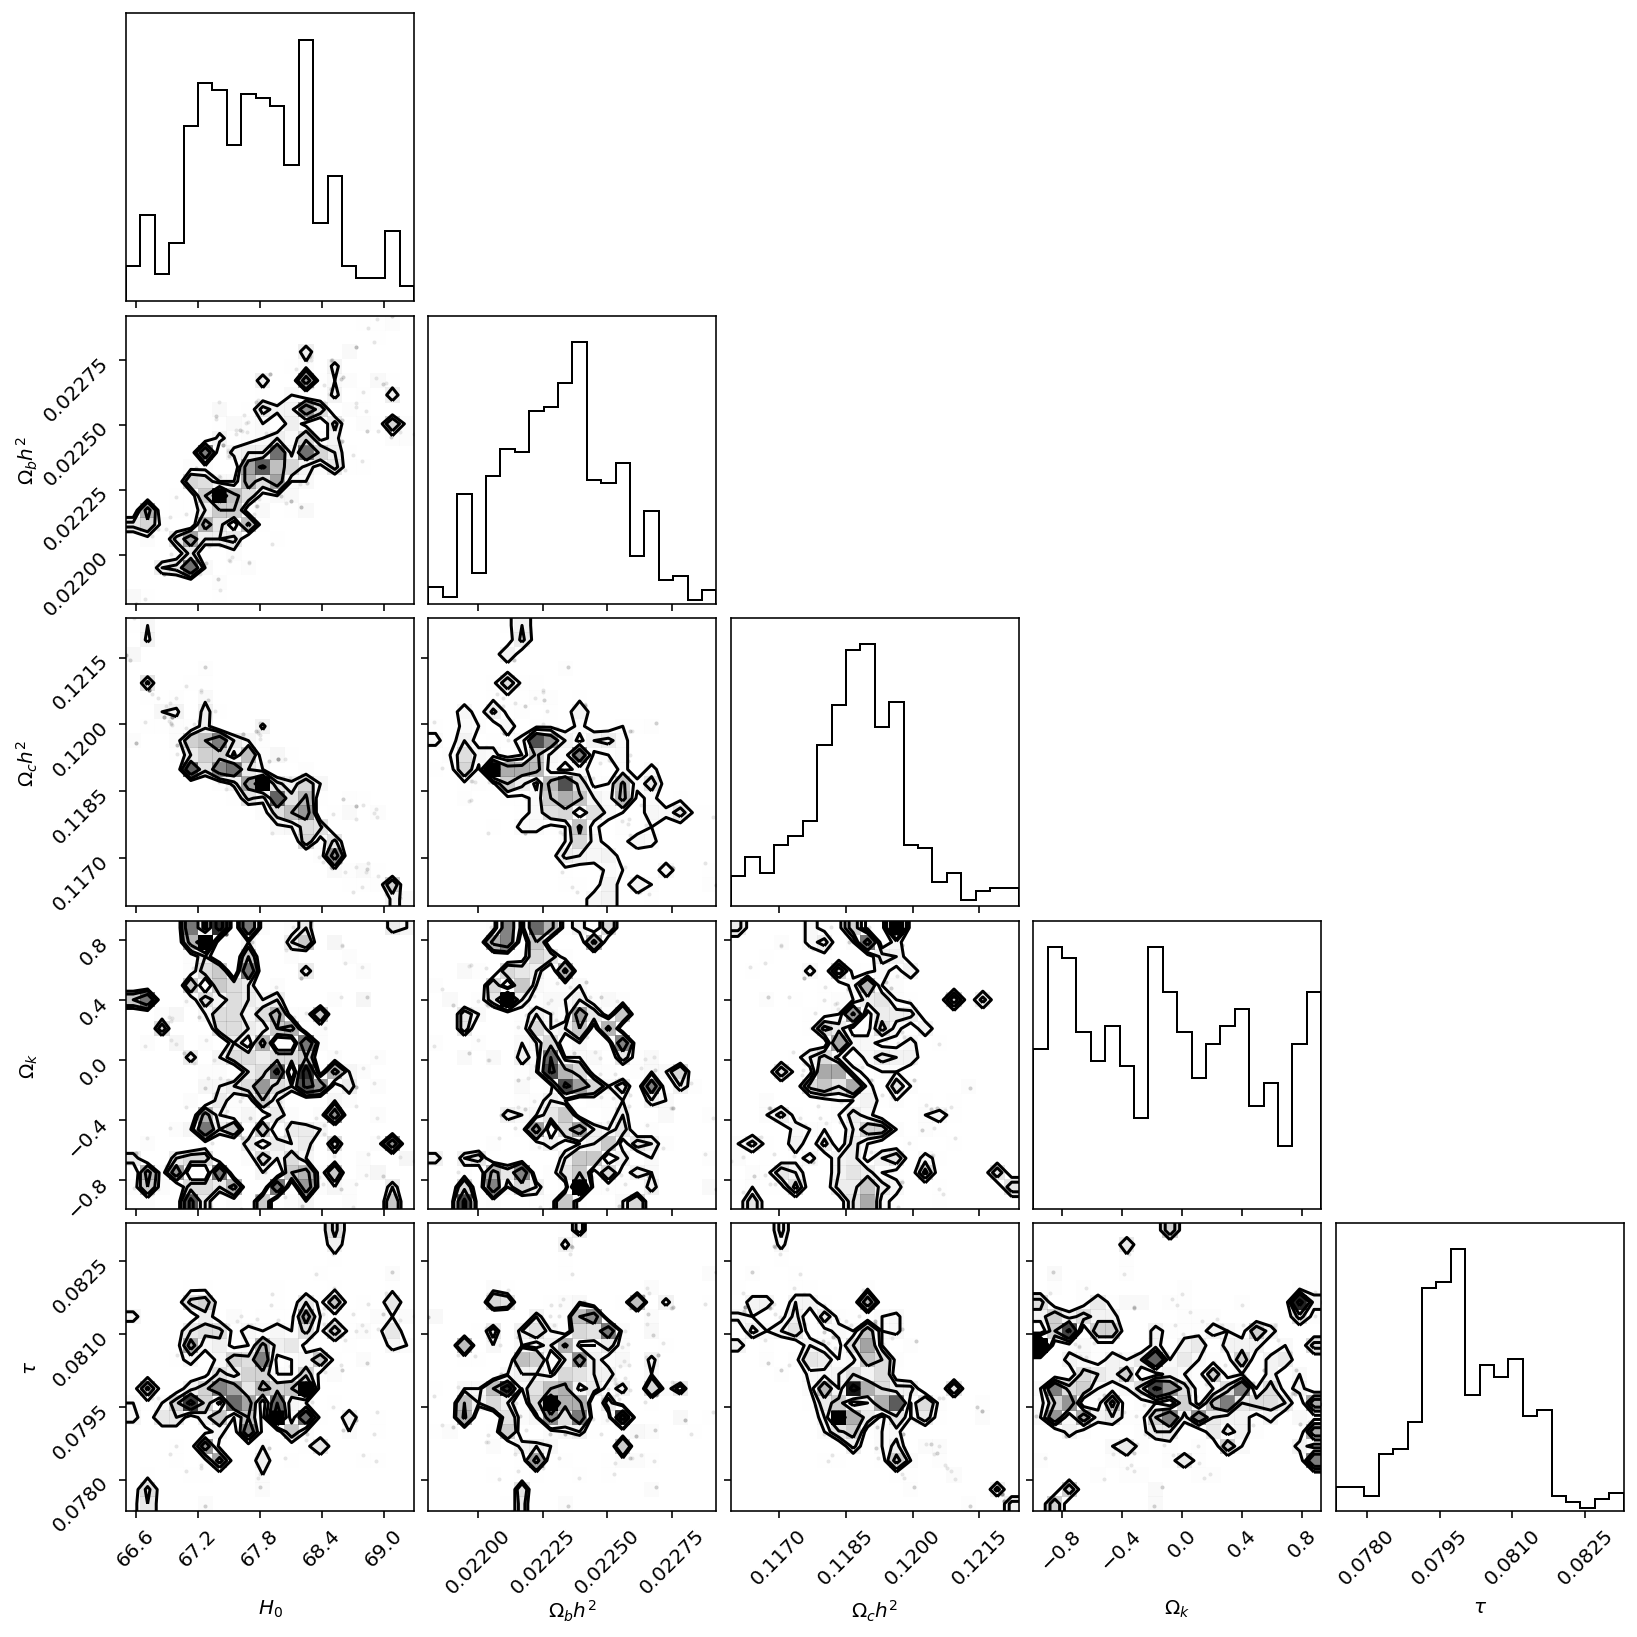

In [33]:
samples = sampler.get_chain(discard=100, thin=1, flat=False)
samples = samples.reshape((-1, len(m.np_values())))
fig = corner.corner(samples, labels=labels)

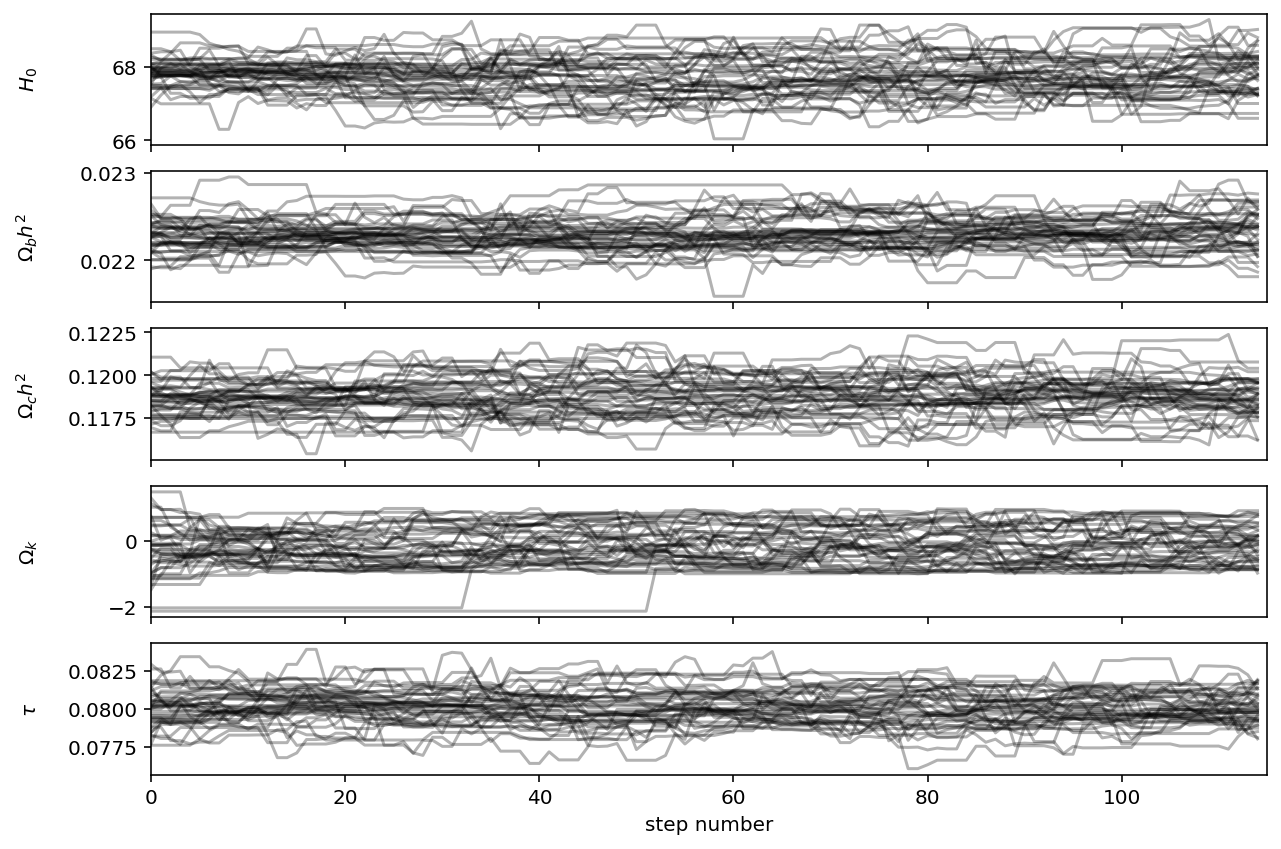

In [34]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [137]:
np.save("cosmo_5param_fullchain.npy",sampler.chain)
np.save("cosmo_5param_fullchainlnprob.npy",sampler.lnprobability)
np.save("cosmo_5param_flatchain.npy",flat_samples)